In [2]:
from scipy.io import loadmat,savemat
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
#from scipy.spatial.distance import squareform
#from cupyx.scipy.spatial.distance import pdist
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import dff
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform

def remove_zero_rows_cols(matrix):
    
    matrix = matrix[~np.all(matrix == 0, axis=1)]
    
    matrix = matrix[:, ~np.all(matrix == 0, axis=0)]
    return matrix

from matplotlib.font_manager import FontProperties
font = FontProperties()

font.set_size(5)  

def compute_dff_Allen(traces, fs):
    """
    traces, 2D array, [ROI, time_points];

    dff.compute_dff_windowed_median()
    
    median_kernel_long=int(600*fs//2*2 +1)        # 600s  5401 = int(600*9//2*2 +1);  allen's fs=9;
    ####### median_kernel_short=int((100/9)*fs//2*2 +1)      #101 = int((100/9)*9//2*2 +1);  allen's fs=9; ##### donot use
    median_kernel_short=int((10/3)*fs//2*2 +1)      # 3.33s  31 = int((10/3)*9//2*2 +1);  allen's fs=9;
    
    """
    index_long = int(300*fs//2*2+1)
    index_short = int((10/3)*fs//2*2+1)

    traces_dff = dff.compute_dff_windowed_median(traces,
                                                 median_kernel_long=index_long,
                                                 median_kernel_short=index_short)
    
    return traces_dff


def compute_dff_Allen_parallel(traces, fs, n_jobs, batch_size):
    """
    traces, 2D array, [ROI, time_points];
    """

    ROI_num = traces.shape[0]

    traces_dff = Parallel(n_jobs=n_jobs)(delayed(compute_dff_Allen)(traces[i:min(i+batch_size, ROI_num), :], fs) for i in range(0, ROI_num, batch_size))

    traces_dff = np.concatenate(traces_dff, axis=0)

    return traces_dff

def pca_reconstruction(data, variance_threshold=0.95, standardize=False):
    
    """
    
    # Data Preprocessing
    if standardize:
        scaler = StandardScaler()
        data_processed = scaler.fit_transform(data)
    else:
        scaler = None
        data_processed = data.copy()

    # PCA 
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(data_processed)
    
    print(f"保留方差比例: {variance_threshold*100}%")
    print(f"选择主成分数量: {pca.n_components_}")
    print(f"累计解释方差: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

    # 数据重构
    reconstructed_processed = pca.inverse_transform(pca.transform(data_processed))
    
    # 逆标准化处理
    if standardize:
        reconstructed = scaler.inverse_transform(reconstructed_processed)
    else:
        reconstructed = reconstructed_processed

    return reconstructed, pca, scaler

In [4]:
exp='testData'
datapath = './'+exp;
data = loadmat(os.path.join(datapath, "Ori3dCellTrace.mat"))

nucArea = data['nucArea'] 
trace = data['trace'] 
nucIndex = data['nucIndex']

smallArea = np.squeeze(nucArea <= 4) # remove small mask to improve trace SNR
trace = np.delete(trace, np.where(smallArea), axis=0) 
# trace = trace[~smallArea,:]
nucIndex = np.delete(nucIndex, np.where(smallArea))

del(data)

traces_dff = compute_dff_Allen_parallel(trace, fs=1, n_jobs=30, batch_size=6)
#traces_dff = trace
reconstructed, _ , _ = pca_reconstruction(traces_dff)#

print('running corr1...')
corr1 = squareform(pdist(reconstructed, "correlation"))
##corr1 = squareform(pdist(traces_dff, "correlation"))
corr1=1-corr1;
indices = np.diag_indices(corr1.shape[0])
corr1[indices] = 0

保留方差比例: 95.0%
选择主成分数量: 23
累计解释方差: 95.10%
running corr1...


In [5]:
nucNo = np.unique(nucIndex) 
neural = np.zeros((len(nucNo), trace.shape[1]))
for i in range(len(nucNo)): 
    sameNuc = nucIndex == nucNo[i] 
    if np.sum(sameNuc) > 1: 
        #neural[i, :] = np.mean(reconstructed[sameNuc, :], axis=0)
        neural[i, :] = np.mean(traces_dff[sameNuc, :], axis=0)
    else: 
        #neural[i, :] = reconstructed[sameNuc, :] 
        neural[i, :] = traces_dff[sameNuc, :]

reconstructed, _ , _ = pca_reconstruction(neural)
print('running corr2...')
corr2 = squareform(pdist(reconstructed, "correlation"))
##corr2 = squareform(pdist(neural, "correlation"))
corr2=1-corr2;
indices = np.diag_indices(corr2.shape[0])
corr2[indices] = 0

保留方差比例: 95.0%
选择主成分数量: 23
累计解释方差: 95.10%
running corr2...


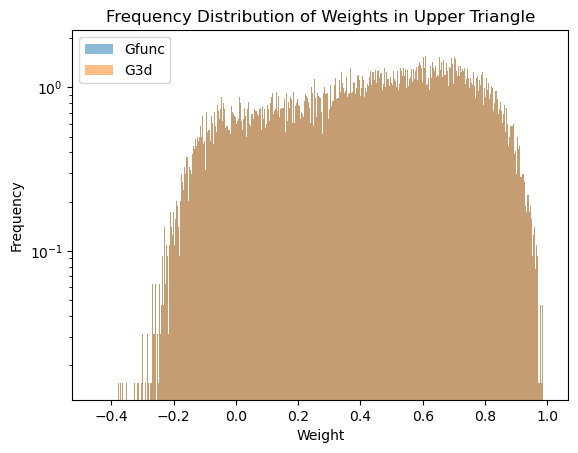

In [6]:
# 提取上三角部分，不包括对角线
upper_triangle = np.triu(corr1, k=1)
# 提取非零元素
weights = upper_triangle[upper_triangle != 0]
# 检查并处理NaN值
if np.isnan(weights).any():
    weights = weights[~np.isnan(weights)]

# 设置bin的范围和数量
#bins = np.linspace(-1, 1, 10000)
# 绘制直方图，10000个bin，y轴log尺度
plt.hist(weights, bins=10000,#bins, 
         log=True,
         density=True,
         label='Gfunc',alpha=0.5)

# 提取上三角部分，不包括对角线
upper_triangle = np.triu(corr2, k=1)
# 提取非零元素
weights = upper_triangle[upper_triangle != 0]
# 检查并处理NaN值
if np.isnan(weights).any():
    weights = weights[~np.isnan(weights)]

# 绘制直方图，10000个bin，y轴log尺度
plt.hist(weights, bins=10000,#bins, 
         log=True,
         density=True,
         label='G3d',alpha=0.5)

# 使用对数刻度
#plt.yscale('log')

# 设置标签和标题
plt.xlabel('Weight')
#plt.ylabel('Frequency (log scale)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Weights in Upper Triangle')
plt.legend()

# 显示图形
plt.show()

del(upper_triangle,weights)

In [7]:
from scipy.sparse.linalg import eigsh

ecGfun={}
ecG3d={}

# 计算最大特征值及对应特征向量
eigenvalues, eigenvectors = eigsh(np.abs(corr1.astype('float32')), k=1, which='LM', 
                                  #maxiter=10000
                                 )
# 计算特征值中心性
eigenvector_centrality = np.abs(eigenvectors[:, 0])
eigenvector_centrality /= np.linalg.norm(eigenvector_centrality, ord=1)  # 归一化

ecGfun[exp]=eigenvector_centrality * (corr1.shape[0] / corr2.shape[0])

In [8]:
# 计算最大特征值及对应特征向量
eigenvalues, eigenvectors = eigsh(np.abs(corr2.astype('float32')), k=1, which='LM', 
                                  #maxiter=10000
                                 )
# 计算特征值中心性
eigenvector_centrality = np.abs(eigenvectors[:, 0])
eigenvector_centrality /= np.linalg.norm(eigenvector_centrality, ord=1)  # 归一化

ecG3d[exp]=eigenvector_centrality

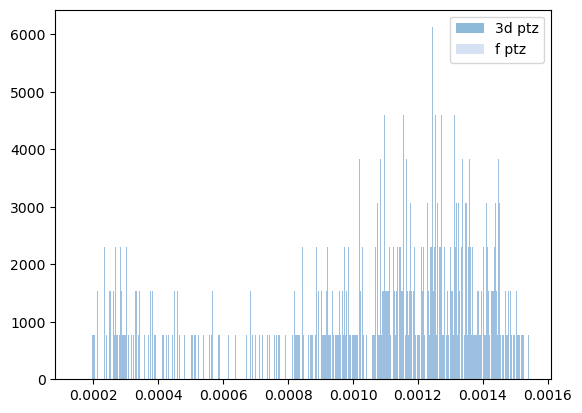

In [9]:
# 设置颜色和透明度
# 使用 Tableau 调色板中的颜色）
colors = [
    (31, 119, 180),  # 蓝色
    (174, 199, 232), # 浅蓝色
    (255, 127, 14),  # 橙色
    (255, 187, 120), # 浅橙色
]

# 将颜色值归一化到 [0, 1] 范围
colors = [(r/255, g/255, b/255) for r, g, b in colors]

alphas = [0.5, 0.5, 0.5, 0.5]  # 不同的透明度
labels=['3d ptz', 'f ptz', '3d spon', 'f spon']

# 绘制直方图
#plt.hist([upper1, upper2, upper3, upper4], bins=10000, color=colors, alpha=alphas, label=['3d ptz', 'f ptz', '3d spon', 'f spon'])

# 绘制直方图
for i, array in enumerate([ecG3d[exp], ecGfun[exp]]):
    plt.hist(array, bins=1000, color=colors[i], alpha=alphas[i], 
             density=True,
             label=labels[i]
            )

#plt.xlim([3.5e-5,4e-5])
# 添加图例
plt.legend()

# 显示图形
plt.show()

In [1]:
import networkx as nx
# 创建网络函数
def create_network(adj_matrix, indexs, threshold=0.95):
    G = nx.Graph()
    n = adj_matrix.shape[0]
    
    # 添加节点及其属性
    for i in range(n):
        G.add_node(i, ind=indexs[i])
    
    # 添加边（仅保留绝对值大于阈值的边）
    for i in range(n):
        for j in range(i+1, n):
            if abs(adj_matrix[i, j]) > threshold:
                G.add_edge(i, j)
    
    # 提取最大连通子图
    largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc)

# 计算网络指标函数
def calculate_metrics(graph):
    print('\nDegree:')
    degree = dict(graph.degree())
    clustering = nx.clustering(graph)
    metrics = {
        'degree': degree,
        'clustering': clustering
    }
    return metrics

# 绘制结果函数
def plot_metric_hist(metric_name, metrics1, metrics2, G1, G2):
    
    fig, ax = plt.subplots(figsize=(15,15))
    cmName1='muted'
    cmName2='pastel'

    nodes = list(G1.nodes())
    metrics1=[metrics1[metric_name][n] for n in nodes]

    nodes = list(G2.nodes())
    metrics2=[metrics2[metric_name][n] for n in nodes]
    
    labels=[f'{exp} treated \nwithout 3d identified', f'{exp} treated \nwith 3d identified']

    #bins=np.concatenate(([0.5,1.5,2.5,3.5,4.5],np.logspace(np.log10(5.5),4,29)))#np.arange(0.5,1e4+1.5)
    bins=np.logspace(0,14,15,base=2)-0.5
    #x=(bins[:-1]+bins[1:])/2
    
    # 绘制直方图
    hist, bins = np.histogram(metrics1, 
                              bins=bins, 
                              density=True);
    x=(bins[:-1]+bins[1:])/2
    
    plt.plot(x[hist>0],hist[hist>0],'o-',
             markersize='12',
             color=sns.color_palette(cmName2)[0],
             label=labels[0]
            )

    hist, bins = np.histogram(metrics2, bins=bins, density=True);
    plt.plot(x[hist>0],hist[hist>0],'o-',
                 markersize='12',
                 color=sns.color_palette(cmName1)[0],
                 label=labels[1]
                )
    
    ax.lines[0].set(linewidth=4, linestyle='--', alpha=0.9)
    ax.lines[1].set(linewidth=4, linestyle='-', alpha=0.9)

    plt.title('Comparison of Degree Distributions',fontproperties=font);
    #ax.set_xlim([1e2,1e4])
    #ax.set_ylim([1e-8,10**(-0.5)])
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Degree',fontproperties=font);
    ax.set_ylabel('Probability',fontproperties=font);
    #ax.set_aspect('equal', adjustable='datalim')
    
    plt.legend(fontsize=32,
               handletextpad=0.5,
               numpoints=2,
               frameon=False)
    
    plt.tick_params(axis='x', which='major',direction='in',length=18 ,labelsize=32,pad=9)
    plt.tick_params(axis='x', which='minor',direction='in',length=9)
    plt.tick_params(axis='y', which='major',direction='in',length=18 ,labelsize=32)
    plt.tick_params(axis='y', which='minor',direction='in',length=9)
    
    ax.spines['left'].set_linewidth(3)   # 左边坐标轴
    ax.spines['bottom'].set_linewidth(3) # 底部坐标轴
    ax.spines['right'].set_linewidth(3)  # 右边坐标轴
    ax.spines['top'].set_linewidth(3)    # 顶部坐标轴
    
    plt.tight_layout()

In [19]:
th = 0.95
G1 = create_network(corr1, nucIndex, th)
G2 = create_network(corr2, nucNo, th)
# 计算两个网络的指标
metrics1 = calculate_metrics(G1)
metrics2 = calculate_metrics(G2)


Degree:

Degree:


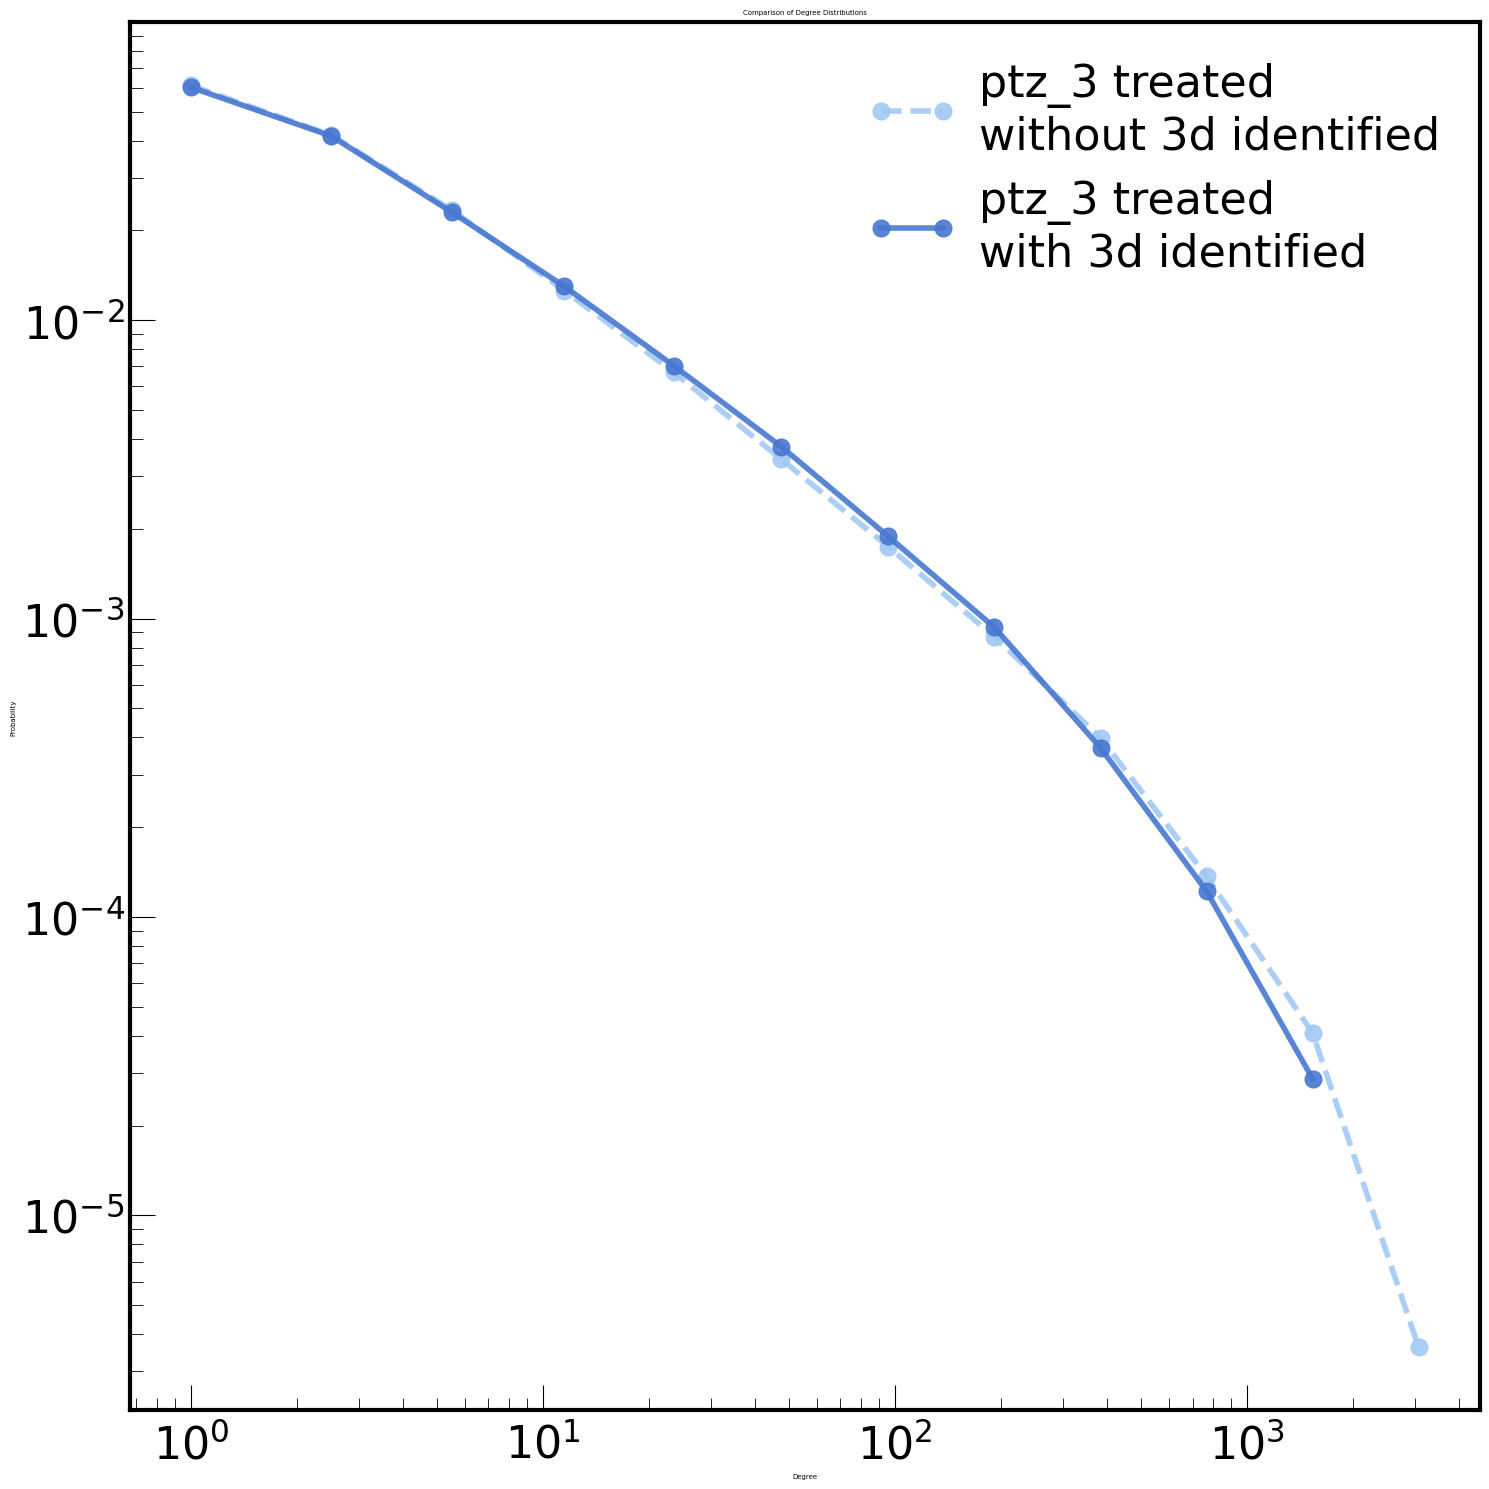

In [20]:
plot_metric_hist('degree', metrics1,metrics2,G1,G2)